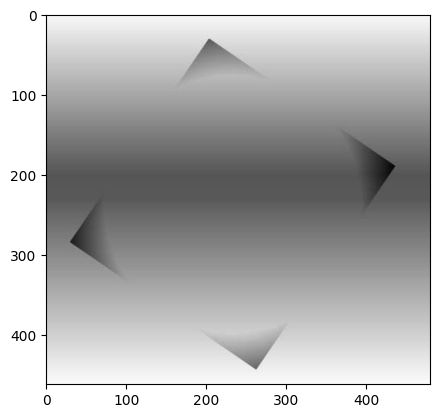

In [130]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

threshold = 50
rho_resolution = 100
theta_resolution = 268
epsilon = 5

# Read the image
image = cv2.imread('contours.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

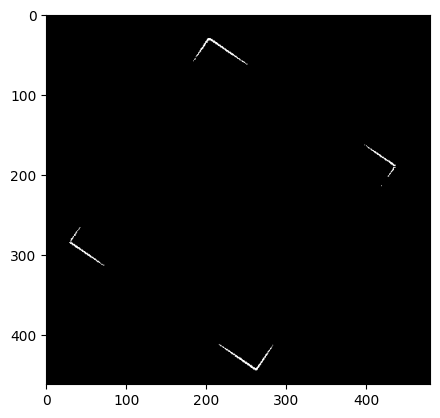

In [131]:
def get_contours(image, threshold):
    # Apply gradient estimation using filter2D
    kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    gradient_image = cv2.filter2D(image, cv2.CV_64F, kernel)

    # Threshold the gradient image to create a binary image
    binary_image = np.where(np.abs(gradient_image) > threshold, 1, 0).astype(np.uint8)
    return binary_image

# Visualize the binary image
binary_image = get_contours(image, threshold)
plt.imshow(binary_image, cmap='gray')
plt.show()

In [132]:
# Construct and visualize the voting space
def imagesc(img1):
    img2 = ((img1 - np.min(img1)) / (np.max(img1) - np.min(img1)))
    plt.imshow(img2, cmap='gray')
    plt.xticks(np.linspace(0, img2.shape[1], 5), np.linspace(-180, 180, 5))
    plt.yticks(np.linspace(0, img2.shape[0], 5), np.round(np.linspace(-np.sqrt(2) * max(img2.shape), np.sqrt(2) * max(img2.shape), 5)))
    plt.show()

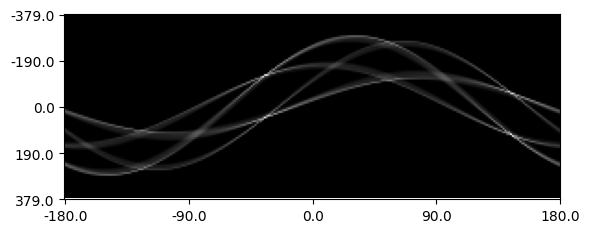

In [133]:
voting_space = np.zeros((rho_resolution, theta_resolution))

min_rho = -np.sqrt(2) * max(image.shape)
max_rho = np.sqrt(2) * max(image.shape)

min_theta = -np.pi
max_theta = np.pi

# get list of pixels where binary_image == 1
for x, y in np.argwhere(binary_image == 1):
    for theta_index, theta in enumerate(np.linspace(0, max_theta - min_theta, theta_resolution)):
        rho = x * np.cos(theta) + y * np.sin(theta)
        
        rho_index = int((rho - min_rho) / (max_rho - min_rho) * rho_resolution)
        voting_space[rho_index, theta_index] += 1

imagesc(voting_space)
    

k = 1
rho = 203.64675298172574, theta = 2.508585178612745
384.25682711178183
385.06307913038404
385.86933114898625
386.6755831675885
384.0421473055931
384.8483993241954
385.6546513427976
386.4609033613998
387.267155380002
388.0734073986042
388.8796594172065
384.6337195180066
385.4399715366089
386.2462235552111
387.05247557381335
387.85872759241556
388.66497961101777
389.47123162962
390.27748364822224
384.41903971181796
385.22529173042017
386.0315437490224
389.2565518234313
390.06280384203353
390.86905586063574
391.675307879238
392.48155989784027
384.2043599056292
385.01061192423145
385.8168639428337
391.4606280730493
392.2668800916515
393.07313211025377
393.879384128856
384.79593211804274
385.60218413664495
386.4084361552472
392.85845230406505
393.66470432266726
394.47095634126947
395.27720835987174
396.083460378474
384.58125231185403
385.3875043304563
395.062528553683
395.86878057228523
396.6750325908875
397.4812846094897
384.3665725056653
385.1728245242675
385.9790765428698
396.46035

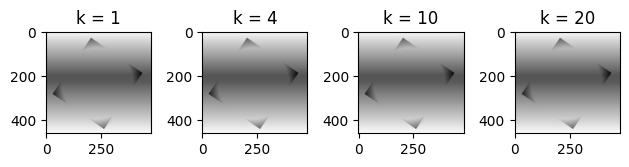

In [140]:
k_values = [1, 4, 10, 20]

for k in k_values:
    lines = []
    vspace = np.copy(voting_space)

    print(f'k = {k}')

    for _ in range(k):
        rho_index, theta_index = np.unravel_index(np.argmax(vspace), vspace.shape)
        vspace[rho_index, theta_index] = 0

        rho = rho_index / rho_resolution * (max_rho - min_rho) + min_rho
        theta = theta_index / theta_resolution * (max_theta - min_theta) + min_theta

        print(f'rho = {rho}, theta = {theta}')

        points = np.argwhere(binary_image == 1)

        # filter points that are close to the line
        def is_valid_point(x, y):
            error = np.abs(x * np.sin(theta) - y * np.cos(theta) + rho)
            print(error)
            return error < epsilon
        
        valid_points = np.array([point for point in points if is_valid_point(*point)])
        print(f'valid points: {len(valid_points)}')

        # find points that are furthest apart in valid_points
        max_distance = 0
        x1, y1, x2, y2 = 0, 0, 0, 0
        for i, point1 in enumerate(valid_points):
            for point2 in valid_points[i:]:
                distance = np.linalg.norm(point1 - point2)
                if distance > max_distance:
                    max_distance = distance
                    x1, y1 = point1
                    x2, y2 = point2

        lines.append((x1, y1, x2, y2))

    plt.subplot(1, len(k_values), k_values.index(k) + 1)
    plt.imshow(image, cmap='gray')
    for x1, y1, x2, y2 in lines:
        plt.plot([x1, x2], [y1, y2], 'g-')
    plt.title(f'k = {k}')

plt.tight_layout()
plt.show()
    